Occlusion Experiment on True and False classifications

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from random import shuffle
import numpy as np
import random

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from sklearn.metrics import confusion_matrix

import re
from tokenize import Double
import cv2
import glob
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sb
from random import sample
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

from random import sample

In [ ]:
class_map = {"Triangle" : 0, "Square": 1, "Pentagon" : 2, "Hexagon"  : 3, "Heptagon": 4, "Octagon"  : 5, "Nonagon"  : 6, "Circle"   : 7, "Star" : 8}

In [ ]:
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3):
        super(Unit,self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=kernel_size,out_channels=out_channels,stride=1,padding=1)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.relu(output)

        return output

class SimpleNet(nn.Module):
    def __init__(self,num_classes=9):
        super(SimpleNet,self).__init__()

        # Create layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32,kernel_size=3)# n, 32, 200, 200
        self.pool1 = nn.MaxPool2d(kernel_size=2) # n, 32, 100, 100

        self.unit2 = Unit(in_channels=32, out_channels=64) # n, 64, 100, 100
        self.pool2 = nn.MaxPool2d(kernel_size=2) # n, 64, 50, 50

        self.unit3 = Unit(in_channels=64, out_channels=128) # n, 128, 50, 50
        self.pool3 = nn.MaxPool2d(kernel_size=2) # n, 128, 25, 25

        self.unit4 = Unit(in_channels=128, out_channels=128) # n, 128, 25, 25
        self.pool4 = nn.MaxPool2d(kernel_size=4) # n, 128, 6, 6

        self.net = nn.Sequential(self.unit1,
                                 self.pool1,
                                 self.unit2,
                                 self.pool2,
                                 self.unit3,
                                 self.pool3,
                                 self.unit4,
                                 self.pool4)

        self.fc1 = nn.Linear(in_features=128 * 6 * 6, out_features=128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 9)


    def forward(self, input):
        output = self.net(input) # Size : [batch_size, 128, 6, 6]
        output = output.view(output.size(0), -1) # Size : [batch_size, 128 * 6 * 6]
        output = self.fc2(self.relu1(self.fc1(output)))
        return output

In [ ]:
model = SimpleNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/Logs/rerun/ML003/model_99.model",  map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
path = "/content/drive/MyDrive/TI-Data/Data/train/*"
samples = sample(glob.glob(path), 400)

without_grayscale = []
imgs = []
labels = []

for path in tqdm(samples):
    word_label = path.split("_")[0].split("/")[-1]
    label = class_map[word_label]

    
    img = cv2.imread(path)
    #without_grayscale.append(img)
    img = transformer(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(torch.tensor(img[None,:], dtype=torch.float))
    labels.append(label)


  3%|▎         | 11/400 [00:02<01:28,  4.41it/s]


KeyboardInterrupt: ignored

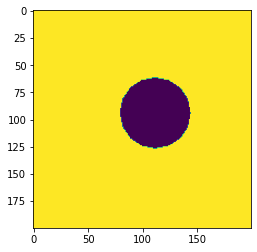

In [ ]:
plt.imshow(imgs[15][0][0])

In [ ]:
def getLabel(index):
    for key, value in class_map.items():
        if(value == index):
            return key

def getIndex(label):
  for key, value in class_map.items():
      if(key == label):
        return value

In [ ]:
Misclassified_images = []
Misclassified_labels = []
Misclassified_index = []
misclassified_count = 0

classified_images = []
classified_labels = []
classified_index = []
classified_count = 0

In [ ]:
COUNT = 30
for index, (img, label) in enumerate(zip(imgs, labels)):
    output = model(img)
    softmax_output = nn.functional.softmax(output, dim = 1)
    prob_no_occ, pred = torch.max(softmax_output.data, 1)
    prob_no_occ = prob_no_occ[0].item()
    

    if(classified_count < COUNT and label == pred.item()):
      print(prob_no_occ, getLabel(label))
      classified_images.append(img)
      classified_labels.append(getLabel(pred.item())) 
      classified_index.append(index)
      classified_count+=1

    if(classified_count >=COUNT):
      break

0.99972003698349 Hexagon
0.9990270137786865 Nonagon
0.999998927116394 Hexagon
1.0 Square
0.9999974966049194 Heptagon
0.9998626708984375 Hexagon
0.9907124638557434 Nonagon
0.9367137551307678 Octagon
0.9999998807907104 Circle
1.0 Square
1.0 Square
0.9983552098274231 Heptagon
0.9639286994934082 Octagon
0.9999996423721313 Triangle
0.9918079972267151 Octagon
0.9999837875366211 Circle
0.9999998807907104 Square
1.0 Circle
0.9992743134498596 Heptagon
0.993986964225769 Nonagon
1.0 Star
1.0 Circle
0.9977959394454956 Nonagon
0.9998900890350342 Nonagon
0.9917812943458557 Octagon
0.9999396800994873 Square
1.0 Circle
1.0 Triangle
0.9919866323471069 Hexagon
0.9999854564666748 Triangle


Resource:
https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=Lh1n930Us4bI

In [ ]:
#custom function to conduct occlusion experiments
def occlusion(model, image, label, occ_size = 100, occ_stride = 5, occ_pixel = 1):

    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            #plt.imshow(input_image[0].permute(1,2,0))

            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

In [ ]:
misclassified_heatmap = []
classified_heatmap = []

In [ ]:
# for index in tqdm(range(len(Misclassified_images))):    
#   misclassified_heatmap.append(occlusion(model, Misclassified_images[index], getIndex(Misclassified_labels[index]), 32, 14))

100%|██████████| 30/30 [04:50<00:00,  9.69s/it]


In [ ]:
for index in tqdm(range(len(classified_images))):    
  classified_heatmap.append(occlusion(model, classified_images[index], getIndex(classified_labels[index]), 20, 10))

100%|██████████| 30/30 [04:43<00:00,  9.46s/it]


In [ ]:
# fig, ax = plt.subplots(ncols=10, figsize=(35,20))

# for i,index in enumerate(Misclassified_index):
#   ax[i].imshow(imgs[index][0].permute(1,2,0))


In [ ]:
# fig, ax = plt.subplots(ncols=10, figsize=(35,20))

# for index, map in enumerate(misclassified_heatmap):
#   cax = ax[index].matshow(map)
# fig.colorbar(cax)

In [ ]:
def example_plot(ax, img, label, fontsize=12):
    ax.imshow(img)
    ax.set_title(label)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

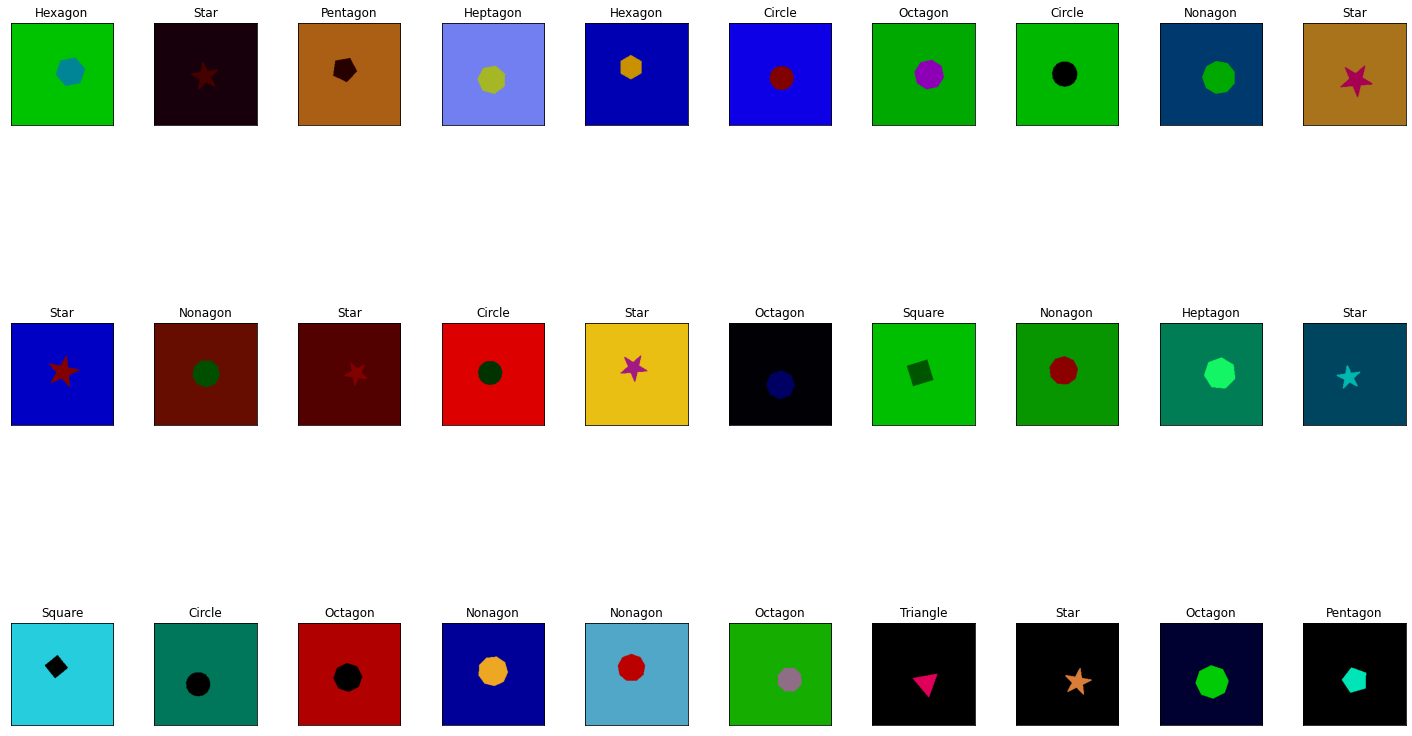

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(25,25))
classifiedIndexIterator = iter(classified_index)
for row in range(3):
  for column in range(10):
    currentIndex=next(classifiedIndexIterator)
    example_plot(ax[row,column], imgs[currentIndex][0].permute(1,2,0), getLabel(labels[currentIndex]))
plt.subplots_adjust(top = 1.2, bottom=0.8, hspace=1.5, wspace=0.4)

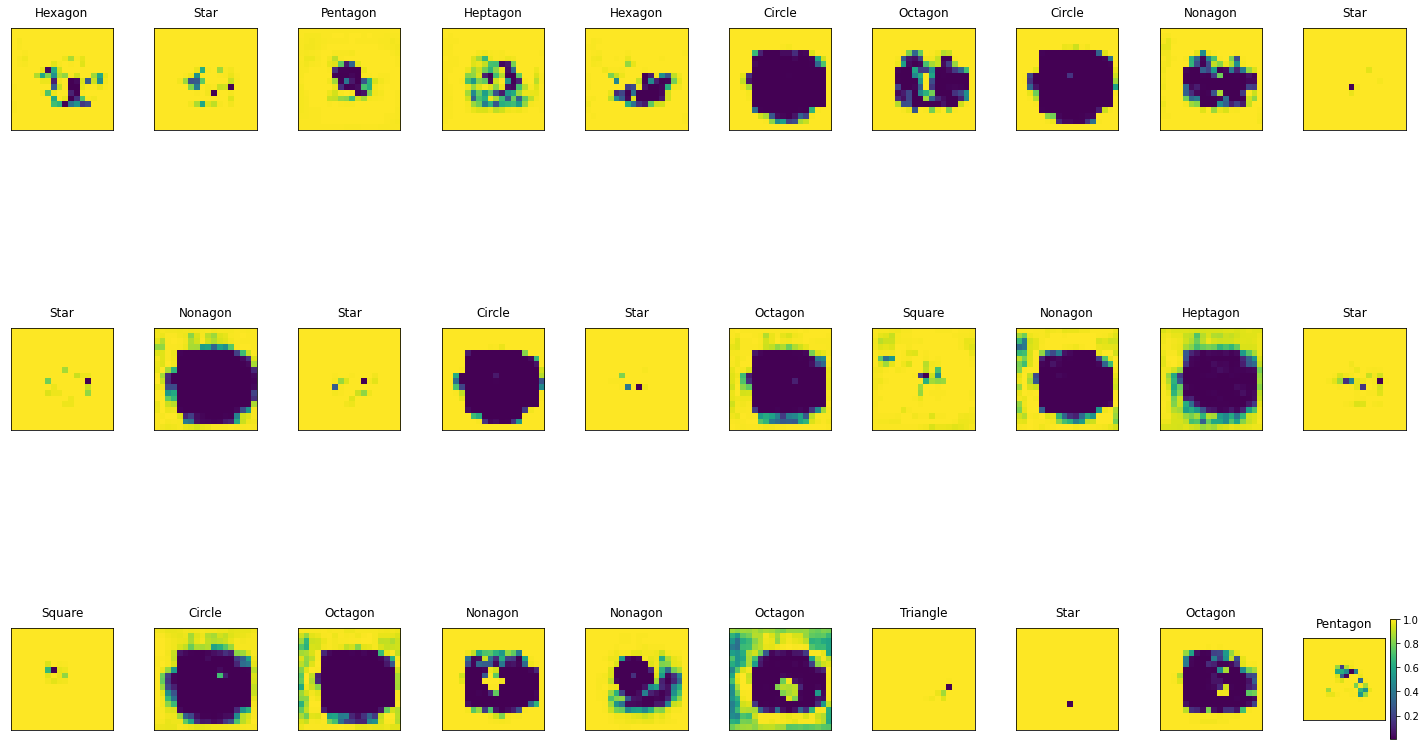

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(25,25))
classifiedHeatMap = iter(classified_heatmap)
classifiedIndexIterator = iter(classified_index)
for row in range(3):
  for col in range(10):
    currentIndex=next(classifiedIndexIterator)
    cax = ax[row, col].matshow(next(classifiedHeatMap))
    ax[row,col].get_xaxis().set_ticks([])
    ax[row,col].get_yaxis().set_ticks([])
    ax[row,col].set_title(getLabel(labels[currentIndex]))

fig.colorbar(cax)
plt.subplots_adjust(top = 1.2, bottom=0.8, hspace=1.5, wspace=0.4)

In [ ]:
import copy

In [ ]:
sortedPaths = {}
epoch_paths1 = glob.glob("/content/drive/MyDrive/Logs/ML001/*")
epoch_paths2 = glob.glob("/content/drive/MyDrive/Logs/ML001*")

for epoch_path1, epoch_path2 in zip(epoch_paths1, epoch_paths2):
    epochNumber = int(epoch_path1.split("/")[-1].split("_")[1].split(".")[0])
    sortedPaths[epochNumber] = epoch_path2


In [ ]:
model = SimpleNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/Logs/rerun/ML003/model_99.model",  map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model.to("cuda")

SimpleNet(
  (unit1): Unit(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit2): Unit(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit3): Unit(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit4): Unit(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (net): Sequential(
    (0): Unit(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (1): MaxPool2d(kernel_siz

In [ ]:
a = cv2.imread("/content/Nonagon_4c88dbde-aae1-11ec-a4a9-1e80c00a4030.png")
b = cv2.imread("/content/Nonagon_7ed5a666-aae2-11ec-a737-1e80c00a4030.png")




at = transformer(a)
bt = transformer(b)

#start_model.load_state_dict(torch.load("/content/drive/MyDrive/Logs/rerun/ML003/model_1.model",  map_location=torch.device('cpu')))
#end_model.load_state_dict(torch.load("/content/drive/MyDrive/Logs/rerun/ML003/model_99.model",  map_location=torch.device('cpu')))

In [ ]:
a_t= at[None,:].to("cuda")
b_t = bt[None,:].to("cuda")

a_occ = occlusion(model, a_t, 6, 20, 10)
b_occ = occlusion(model, b_t, 6, 20, 10)

Text(0.5, 1.05, 'Occlusion')

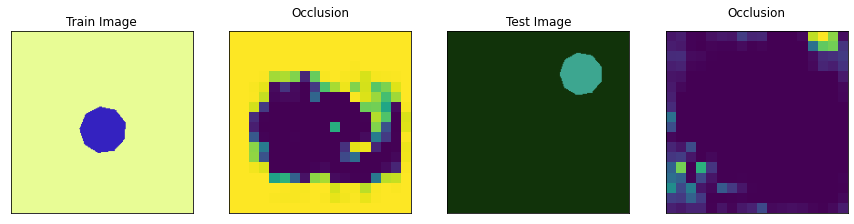

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(15,5))
ax1.imshow(a)
ax2.matshow(a_occ)
ax3.imshow(b)
ax4.matshow(b_occ)



ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title("Train Image");
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title("Occlusion")

ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title("Test Image")
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.set_title("Occlusion")

In [ ]:
iterator1 = iter(a_list)
iterator2 = iter(b_list)
iterator3 = iter(c_list)
iterator4 = iter(d_list)

iterator5 = iter(sortedPaths.keys())

for i in range(139):
    fig, (ax3, ax4, ax5, ax6) = plt.subplots(ncols=4, figsize=(15,5))
    ax3.imshow(dd)
    ax4.matshow(next(iterator4))
    ax5.imshow(bb)
    ax6.matshow(next(iterator2))

    epochNumber = next(iterator5)

    
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title("Train Image");
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    ax4.set_title("epoch:"+ str(epochNumber))

    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.set_title("Test Image")
    ax6.get_xaxis().set_visible(False)
    ax6.get_yaxis().set_visible(False)
    ax6.set_title("epoch:"+ str(epochNumber))
    

    fig.savefig("/content/drive/MyDrive/OcclusionEpochs4/"+str(epochNumber)+".png")
    plt.close(fig)

In [ ]:
sortedOccPaths = {}
for path in glob.glob('/content/drive/MyDrive/OcclusionEpochs4/*.png'):
    key = int(path.split("/")[-1].split(".")[0])
    sortedOccPaths[key] = path

In [ ]:
import cv2
import numpy as np
import glob
 
img_array = []
for i in range(289):
  if i in sortedOccPaths.keys():
    img = cv2.imread(sortedOccPaths[i])
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('/content/sample_data/ScaleInvariance.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 3, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()